# Meta-modeling tutorial

### Tanmoy Sanyal, Sali lab (tsanyal@salilab.org)

Hi everyone, and welcome to this brief tutorial that provides a demonstration of Sali-lab's current efforts in metamodeling. In a nut-shell "meta-modeling" is the process of establishing a platform that can harmonize different computational models of the cell.

The focus of this tutorial is on a (hopefully!) hands-on demonstration of how this platform works, so for computational simplicity, the <em>cell models</em> used here are toy models. It is instructive that you do <strong>not</strong> go looking for biological meaning in the results shown below, but rather follow the computational aspect of how we can design platforms that enable information flow between different seemingly disparate simulation models.

The tutorial is divided into three sections with increasing complexity. To keep the material general enough, certain concepts and implementation have been intentionally coarse-grained out. Please feel free to interrupt and ask questions in between, or, for in-depth discussions, reach out to me later. 

## 1. Probabilistic graphical models (PGM) and probabilistic programming languages (PPL)

The framework that we'll eventually use to implement metamodeling is a <strong>Probabilistic graphical models</strong>. These are graphical representations of complex joint probability distributions that enable efficient data storage and systematic protocols to understand the conditional inter-dependencies between different parts of the model (or for that matter different models, as we shall see in part-3). <strong>Probabilistic programming languages</strong> are frameworks built in well known (surprise, surprise) programming languages that enable fast Bayesian operations on such graphical models. In this tutorial, we'll use a well-known PPL called [PyMC3](https://docs.pymc.io), which is built on top of fast machine-learning libraries like [Theano](http://deeplearning.net/software/theano/) or [Tensorflow](https://www.tensorflow.org/). 

The central tenet of building simulation models, that is very close to all of our hearts (especially at Sali lab), is that all models are posterior densities, of the form $$P(M \mid D, I)$$, i.e. the degrees of freedom of the model, M, (these could be anything, particle coordinates, chemical concentrations, time-varying or static) are posterior probabilities <em>conditioned</em> on available data D and other parameters I, that we call "information". (In this tutorial, I will call them parameters for the most part.) In fact, the ability to describe P given different sets of data D is <strong>Integrative Modeling</strong> as we know it today. But not all data may be available to all models, e.g. a pharmacokinetic (PK/PD) type of model deals with concentrations so presenting it with data on molecular co-ordinates would not make sense. That is where "meta-modeling" comes in! In metamodeling, we try to couple not just all available data to a single model, but different models that may or may not have their own "appropriate" data.

Lets not get ahead of ourselves right now, and focus back on how a PGM is implemented. For starters, what does it even look like? To demonstrate this, let take the classical example of linear regression. Essentially we'll try to fit a line to some data, <em>but, in a Bayesian manner</em>.

First, we import some of the necessary python libraries:

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt



Now, lets generate some fake data. Essentially generate points on a straight line and add some noise to them!

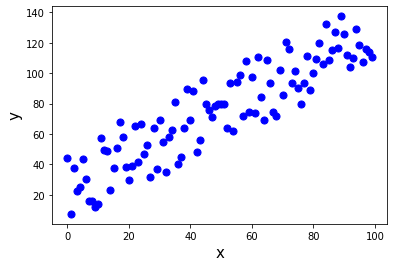

In [2]:
npoints = 100

target_m = 1.0 # slope
target_c = 2.0 # intercept

x = np.arange(npoints)
y = target_m * x + target_c
y_noised = y + 50*np.random.random(npoints)

plt.scatter(x, y_noised, c="blue", s=50)
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.show()

### 1.1 Hierarchial linear Gaussian model
We can write a <em>hierarchical</em> linear gaussian model to explain the noisy data in the plot above.

$$m \sim \mathcal{N}(\mu_0, \sigma_0)$$ $$c \sim \mathcal{N}(\mu_1, \sigma_1)$$ $$y = mx+c$$ $$y_{noised} \sim \mathcal{N}(y, \sigma_3)$$

Essentially we are imposing our prior belief on the slope(m) and intercept(c) to be normally distributed. Then we represent our model as y=mx+c and finally we propose that the observed data is also distributed normally around our model's calculated y values. (In this particular case, this is a strongly correct assumption since we already know that the data was generated from a straight line, but we may not be so lucky with more complex models). These specifications are <strong>nested</strong> within one another, hence the name <strong>hierarchial</strong>. The normal distributions we imposed on m and c are called <strong>priors</strong> while the parameters mu and sigma that characterize these distributions are called <strong>hyperpriors</strong>.

Alright, what does this model look like graphically?

Again, we import a few libraries. Some of these are actually wrappers written over PyMC3 to facilitate working with probabilistic graphical models. And the tutorial_utils module is a bunch of functions to make life simpler for me while writing this tutorial (:P)

In [3]:
import pymc3 as pm # the PyMC3 package

sys.path.append("..")
from mm.core import jit # custom-wrapper for model compilation

import tutorial_utils as tu

Now lets define the model, basically write out the three equations above in PyMC3 specific syntax.

In [4]:
@jit
def linear_model(name="linear_model", inputs={}, evidence={}, start={}):
    mu_0 = 1.5
    sigma_0 = 0.1
    m = pm.Normal("m", mu=mu_0, sigma=sigma_0)
    
    mu_1 = 2.5
    sigma_1 = 0.1
    c = pm.Normal("c", mu=mu_1, sigma=sigma_1)
    
    x = inputs["x"]
    y = pm.Deterministic("y", m*x + c)
    
    sigma_3 = 10
    y_noise = pm.Normal("y_noised", mu=y, sigma=sigma_3, shape=len(x))

That's all there is to it! We defined a function that creates a model called "linear model" and adds the variables m, c, y and y_noise to it. Lets' visualize the graphical model that PyMC3 created! The PGM here is rendered in what is known as "plate" notation. The rectange surrounding y_noise is called a <em>plate</em> and it is implied to be repeated for the number of times (in this case the number of datapoints = 100) written at the bottom right corner of the plate.

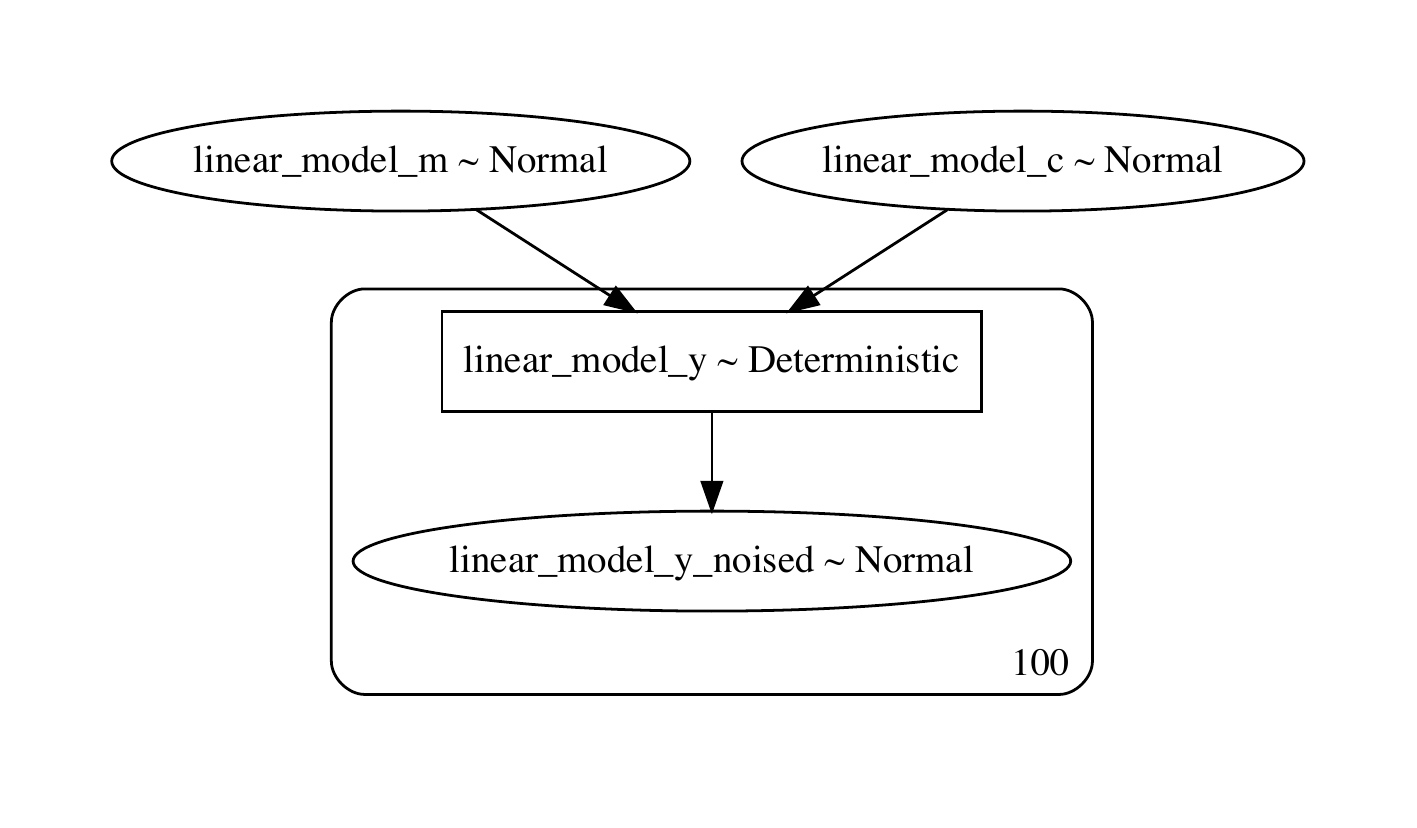

In [5]:
m1=linear_model(name="linear_model", inputs={"x":x}, evidence={}, start={})
tu.visualize_model(m1)

### 1.2 Important terminology
These terms will be helpful later on. For the sake of generality, I'll keep these descriptions short. You are encouraged to discuss / reach out later, if you have questions.

1. <strong>jit</strong> This is a decorator that sits on top of the model builder function (linear_model()) and it delayes the <strong>I-E-S</strong> (input, evidence, start) specification to the model till compile time. Fun fact, it also appends the name of the model to the name of the nodes, so that m becomes "linear_model_m", etc. Hence the name "jit" which stands for "just-in-time" compilation.


2. <strong>inputs</strong>: This is a dictionary of variables that are supplied to the model to be used as is. In this case, it was the array of independent variables x. Note that for this problem, the input x is <em>not</em> assigned a node in the PGM, because it is not a random variable. But in general inputs can be other random variables, even belonging to other models and in fact, this construct presents the principle point of entry of information from one model to another when doing meta-modeling.


3. <strong>evidence</strong>: evidence represents the data that we use to train our model. In this case, it will be the noisy values of y generated before (the blue scattered dots). For reasons of numerical stability that I'll not mention here, it is recommended that <strong>you do not provide evidence to nodes that are roots</strong>, i.e. nodes like m and c, that don't have parents. Only provide evidence to nodes like y_noise that have parents.

4. <strong>start</strong> : start contains starting points (t=0 values) of variables that are dynamic i.e. timeseries. All variables for this simple model are static so start is empty.

### 1.3 Bayesian inference in action
After providing evidence to a model we can <strong>train</strong> it to update the prior distributions to more refined values representing the uncertainty of the data. For training, we use something called <strong>variational inference</strong> which, in a nutshell, is an approximate form of sampling the posterior distributions P(m | y_noise) and P(c | y_noise). Lets create another model instance, this time providing evidence. Note that while providing evidence, you must use the final full name of the variable in the compiled model (i.e. add the name of the model, "linear_model" before it)


Building linear model...


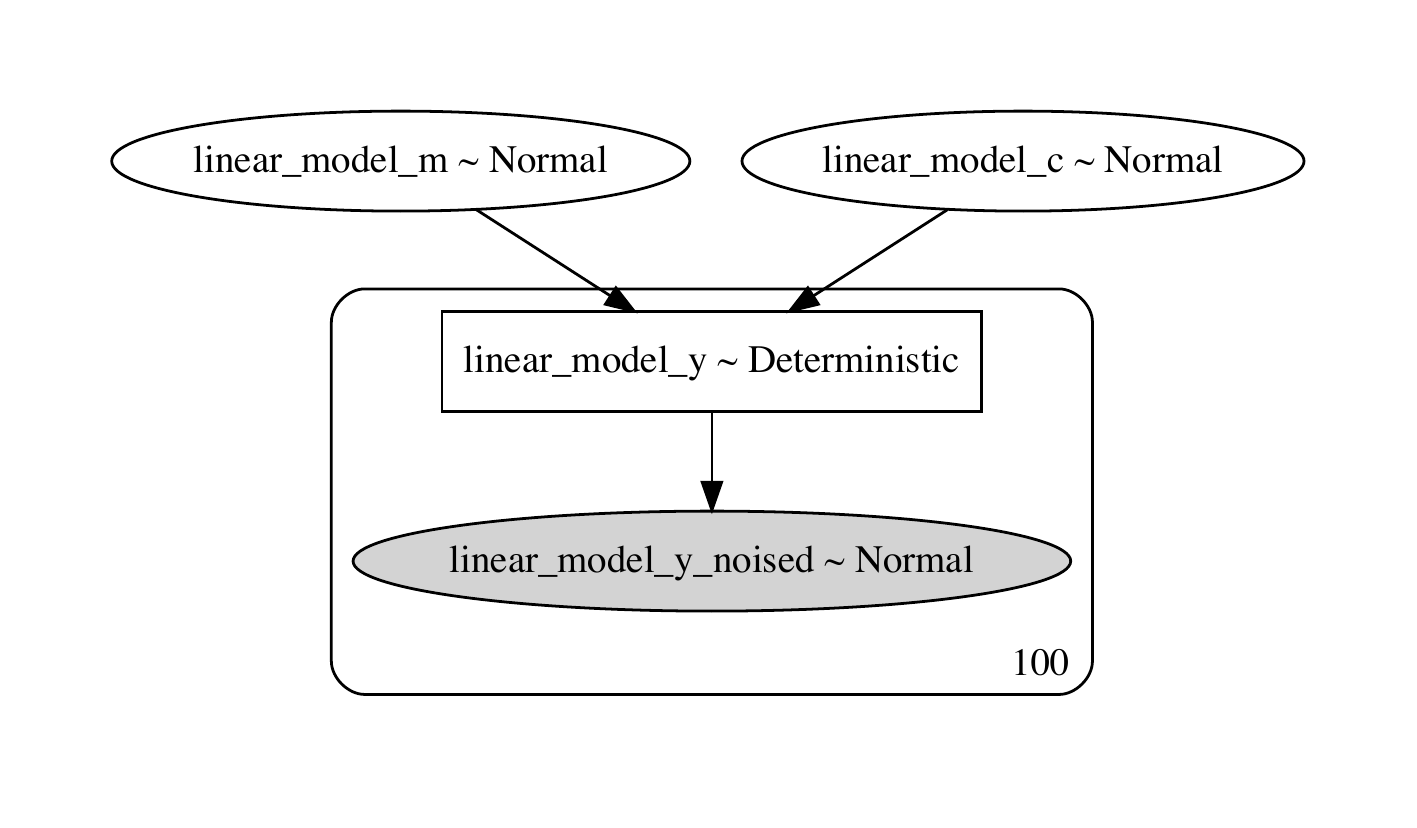



Training on noisy y data...


Average Loss = 491.96: 100%|██████████| 20000/20000 [00:06<00:00, 2992.79it/s]
Finished [100%]: Average Loss = 491.95




Converting all samples to histograms..

Validating by recalculating y = mx+c...


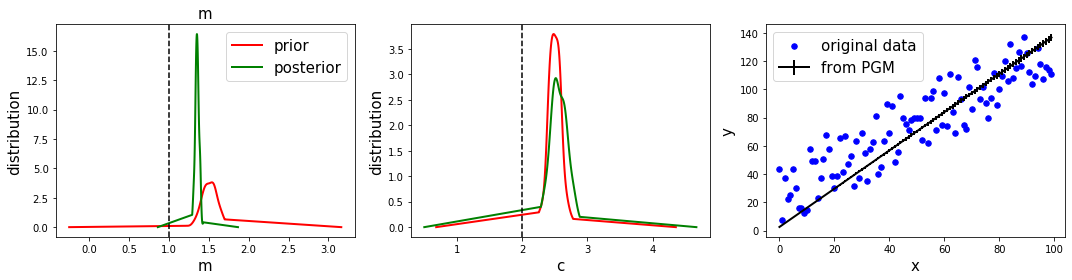

In [6]:
# build the model with evidence
print("\nBuilding linear model...")
m2 = linear_model(name="linear_model", inputs={"x": x}, evidence={"linear_model_y_noised": y_noised})

# visualize the model
tu.visualize_model(m2)

# number of samples
ns = 100

# before the distributions for m and c can get updated due to training, collect their priors
# this will be useful for plotting later
print("\nCollecting prior samples of m and c...")
m_pri_samples = tu.get_prior_samples(m2, "m", samples=ns)
c_pri_samples = tu.get_prior_samples(m2, "c", samples=ns)

# train the model (i.e. sample from the posterior distributions of m and c given y_noise)
# this returns a "trace" which is a dictionary containing samples from the posterior distributions
print("\nTraining on noisy y data...")
_, trace = tu.sample_posterior(m2, tune=20000, samples=ns)

# collect posterior samples
print("\nCollecting posterior samples of m and c...")
m_post_samples = trace["linear_model_m"]
c_post_samples = trace["linear_model_c"]

# convert samples to distributions
print("\nConverting all samples to histograms..")
m_pri = tu.get_distribution(m_pri_samples, vartype="static", smooth=True)
c_pri = tu.get_distribution(c_pri_samples, vartype="static", smooth=True)

m_post = tu.get_distribution(m_post_samples, vartype="static", smooth=True)
c_post = tu.get_distribution(c_post_samples, vartype="static", smooth=True)

# validation: re-calculate new noisy values of y this time from the PGM!
print("\nValidating by recalculating y = mx+c...")
y_new_samples = np.array([m_post_samples[i]*x + c_post_samples[i] for i in range(ns)])
y_new, y_new_err = tu.get_distribution(y_new_samples, vartype="dynamic")

# plot prior vs posterior
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("m", fontsize=15)
ax1.set_xlabel("m", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(m_pri[0], m_pri[1], "r-", lw=2, label="prior")
ax1.plot(m_post[0], m_post[1], "g-", lw=2, label="posterior")
ax1.axvline(target_m, color="k", ls="--", lw=1.5)
ax1.legend(prop={"size": 15})

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("c", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(c_pri[0], c_pri[1], "r-", lw=2)
ax2.plot(c_post[0], c_post[1], "g-", lw=2)
ax2.axvline(target_c, color="k", ls="--", lw=1.5)

ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("x", fontsize=15)
ax3.set_ylabel("y", fontsize=15)
ax3.scatter(x, y_noised, s=30, c="blue", label="original data")
ax3.errorbar(x, y_new, yerr=y_new_err, color="black", lw=2, label="from PGM")
#ax3.fill_between(x, y_new-y_new_err, y_new+y_new_err, color="black", alpha=0.3)
ax3.legend(prop={"size": 15})

fig.tight_layout()
plt.show()


Note that evidence in the PGM is indicated by shading a node. After this experiment, we see that we have been able to update our belief from the prior distributions of m and c to their posterior. Although the posterior means are still off from the true target values of m and c (indicated by dotted lines), the posteriors definitely capture the uncertainty of the training data presented to them. This can be seen from:

1. The posterior of m being much narrower, so that now we have more confidence in its estimate.


2. Recalculating y from the PGM (the black line in the third plot) produces a very good fit with very low uncertainty.(the errorbars are barely visible)

Could we have done better to capture the targets? The answer is yes, and it requires sampling the posterior using more accurate methods than the simple approximate variational inference we use here. But such methods are computationally intensive and are best left out of an interactive tutorial like this. Please feel free to reach out if you would like to learn more.

### 1.4 Summary

The key take away messages from this section are:

1. Probabilistic graphical models help us visualize and perform posterior estimation for probability distributions over several variables.


2. Probabilistic programming languages like PyMC3 offer a very user-friendly implementation of Bayesian inference problems in such graphical models.


3. Estimating posteriors given data (evidence) may help reduce uncertainty in the prior estimates of model parameters. As we shall see in the next section, this statement carries over to meta-modeling too. 

## 2. Building and deploying a simple meta-model to estimate parameters of models

In this section, we'll combine simple models into a meta-model to estimate parameters of either model. You have already seen how a probabilistic model can be built in the previous part. Here, we have made the task easier for you so that you can just import pre-built models. For this section, we'll consider only two models: the <strong>meal model</strong> and the <strong>spt model</strong>. Fair warning though, the model PGMs don't look too pretty, because of the large number of nodes.


Meal Model


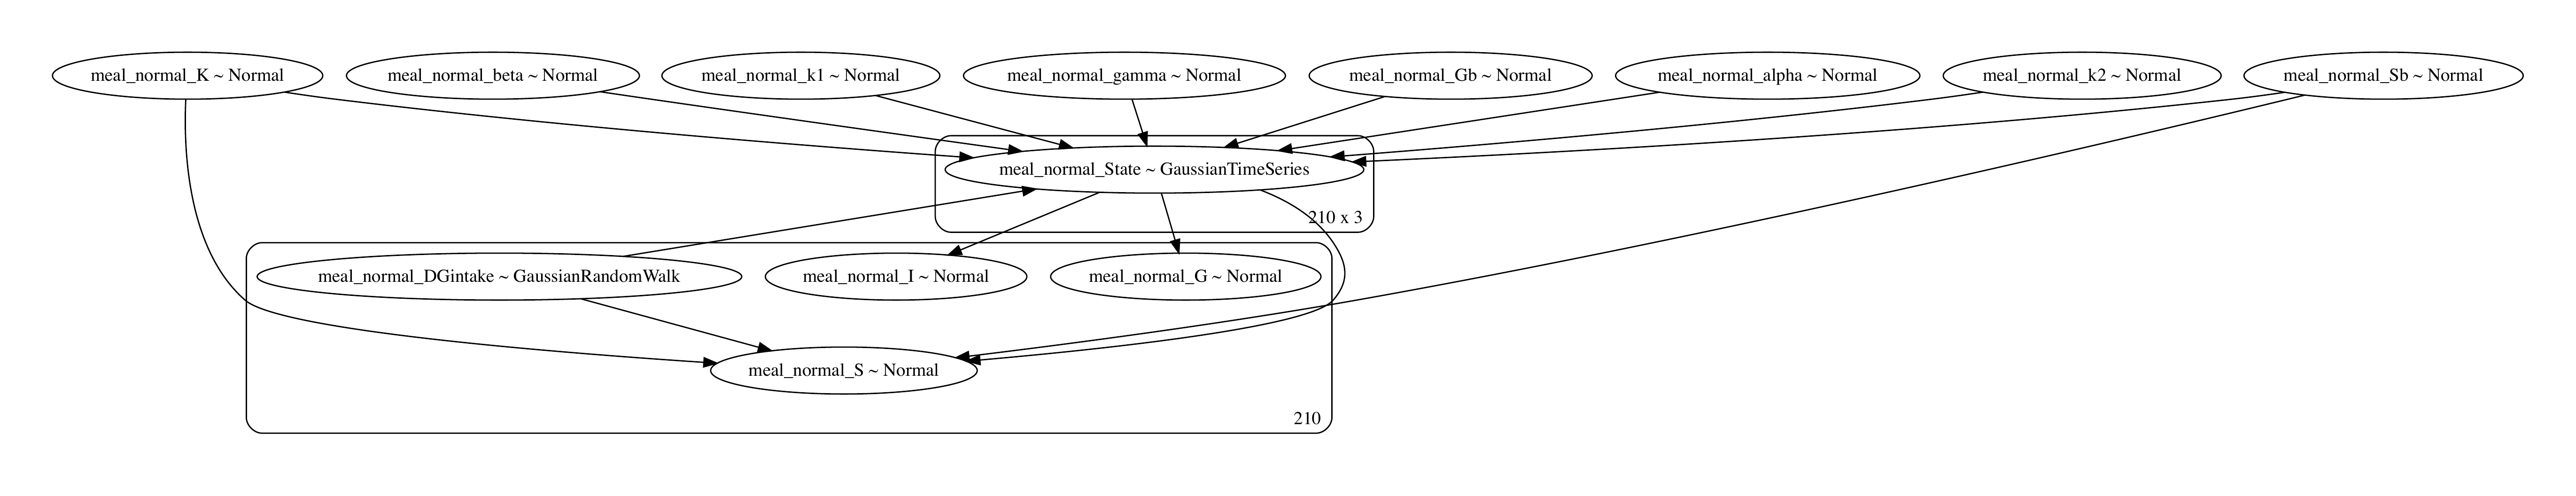


SPT Model


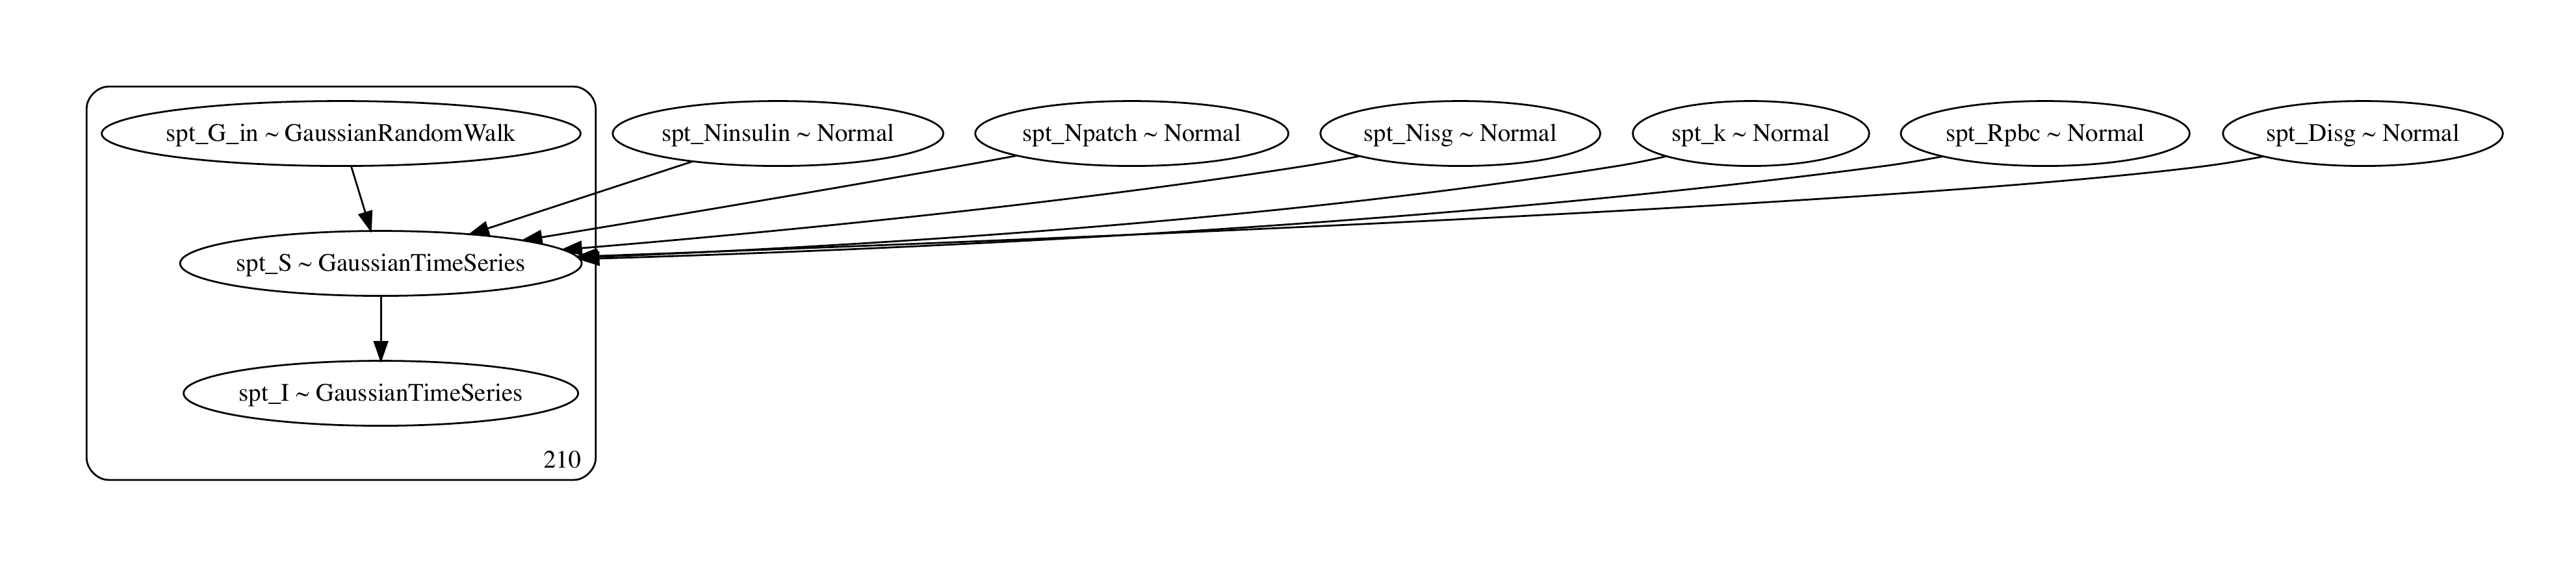

In [9]:
from mm.models import MealModel, SPTModel

meal_1 = MealModel(name="meal_normal", inputs={}, evidence={}, start={}, t=210, hpfn="default_params.json")
spt_1 = SPTModel(name="spt", inputs={}, evidence={}, start={}, t=210, hpfn="default_params.json")

print("\nMeal Model")
tu.visualize_model(meal_1)

print("\nSPT Model")
tu.visualize_model(spt_1)

### 2.1 Meal model
The meal-model is basically a well-known pharamcokinetic model for glucose induced postprandial insulin secretion composed of ordinary differential equations (ODE)s. You can find further details in [this paper](https://ieeexplore.ieee.org/document/4303268). We modified parts of the model so that you can think about it as a simulator that takes as input a concentration profile of ingested glucose (Gintake) and its derivative (DGintake) and produces the reponse concentrations of plasma glucose (G), plasma insulin (I) and insulin secretion rate (S), spatially averaged over the whole pancreas, on the timescale of mins. Two versions of the different model parameters are available in the literature: for healthy and type-2 diabetes (t2d) patients. 

### 2.2 SPT model
SPT stands for (SP)atio-(T)emporal and represents a toy demonstration of a (Brownian dynamics) particle simulator model of the intracellular insulin secretion. As advised before, this simulator is not biologically accurate.

1. The full version of the simulator itself is a much-much simplified representation of the secretion process, where insulin granules are treated as patchy particles that respond to collisions from diffusing glucose molecules, as well as harmonic forces from the cell-wall which represent coarse-grained actin filament interactions.Due to both active (harmonic actin, glucose colliding) and passive (self-diffusing) transport mechanisms, insulin granules are transported to the cell-wall where they can get secreted.


2. The SPT model in this example is a <strong>further simplification in terms of lengths and time-scales in that we assume that the intra-cellular glucose and insulin concentrations as well as insulin secretion rates are at comparable length and time-scales to the meal model</strong>. Relaxing this assumption will need more robust coupling strategies that mitigate the length and time-scaling issues between the characteristic time-scales of a PK/PD model (~mins) and a mesoscopic particle simulation model (~ps at best)


3. The length-scaling is acheived internally by treating each beta-cell as an independent secretory unit so that the total secretion from the pancreas is simply # of cells * individual secretion.



### 2.3 Coupling the two models (with a healthy dose of meta-modeling philosophy!)
The crucial protocol that allows one to couple two or more models represented as graphical models is the fact that putting an edge between two nodes in a graphical model may create <strong>active trails</strong> which initiate information flow between them. As shown in the figure below, these (red) edges can be between nodes belonging to different input models.

<div><img src="./content/mm_meal_spt.png" width="800"/></div>

Thus, here the glucose concentration profile for the intra-cellular spt model is implemented as an "input" (see section 1.2) taken from the plasma glucose concentration profile for the meal model. Further the plasma insulin concentrations from both models are combined to produce a hybrid insulin profile (I_meta in the figure above) which carries information from both models. Why would anyone want to do such a hybrid combination, you ask? Remember, this is a toy example focused on demonstrating the information flow processes!

This also points to a very important note about the meta-modeling philsophy. <font color="red">It has come to our attention that a lot of you have thought about meta-modeling as gathering different pieces of information (experimental data, e.g.) and putting everything together into a [CellPack](http://www.cellpack.org/) model.</font> While that is certainly a possible direction, our approach is agonstic to model representation. If one adopted the CellPack approach, one would be finally working in terms of particle coordinates as the over-arching representation. In fact, this is also how the [Integrative Modeling Platform (IMP)](https://integrativemodeling.org/) from Sali lab is currently organized. <strong>With meta-modeling however, we can let the models have their own representation with very different degrees of freedom. The meal model e.g. consists of only chemical concentrations while the spt model (in principle, considering the full Brownian dynamics simulator) need contain only particle coordinates. The statistical framework offered by PGMs is the representational unification magic that makes meta-modeling (in its current form possible)!</strong>

Moving on, we will create a meta-model from the (pre-built) meal and spt models and use the two couplers mentioned above. Quick note: we will pass an argument called hpfn to all model-builder functions. This stands for (h)yperprior (f)ile(n)ame. It is a json file containing all the hyperpriors (sigmas for Gaussian distributions, starting values for timeseries variables, etc). For this tutorial, a set of best-guess estimates of these quantities (meticulously curated by Liping Sun, Sali lab) have been kept in a file called "default_params.json".

In [ ]:
HP_FN = "default_params.json"

@jit
def MetaModel_1(name="meta_1", t=100,
                inputs={}, evidence={}, start={}, 
                hpfn=HP_FN, mealmodel_type="normal"):
    
    # build the meal model
    mealmodel_name = "meal_%s" % mealmodel_type # normal or t2d
    meal = MealModel(name=mealmodel_name, t=t, inputs=inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    
    